In [1]:
from related_generator.post import Post
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
import umap
from pathlib import Path
from tqdm.notebook import trange, tqdm
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize
import nltk
import numpy as np
from multiprocessing import Pool
# from concurrent.futures import ThreadPoolExecutor
import time

nltk.download("punkt")
%matplotlib widget

[nltk_data] Downloading package punkt to /home/wint3rmute/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
import math
import markdown
import subprocess
from dataclasses import dataclass, field
from pathlib import Path

from bs4 import BeautifulSoup
from typing import Optional


@dataclass
class Post:
    title: str
    content: str
    path: Path

    related_links: list[str]
    
    tf_idf_position: list[float]
    lsa_position: list[float]
    
    # To be filled by map generation
    x: float = 0.0
    y: float = 0.0

    @classmethod
    def from_path(cls, path: Path):
        content_raw = path.read_text()
        html_tree = BeautifulSoup(content_raw, features="html.parser")
        
        # Get links from <nav>
        content_raw = path.read_text()
        html_tree = BeautifulSoup(content_raw, features="html.parser")
        nav_links = [l.attrs["href"] for l in html_tree.nav.find_all("a")]
        
        # Important: nav + footer MUST BE removed for later processing stages
        html_tree.nav.decompose()
        html_tree.footer.decompose()
        
        # Get 'Incoming' links
        incoming_links = cls.find_incoming_links(path, html_tree) or []
        
        content = html_tree.text.replace("\n", "")
        title = path.name

        to_trim = content.rfind("Incoming:")
        if to_trim != -1:
            content = content[to_trim:]
       
        related_links = list(set(nav_links) | set(incoming_links))
        return cls(title=title, content=content, path=path, related_links=related_links, tf_idf_position=None, lsa_position=None)
    
    @staticmethod
    def find_incoming_links(path, html_tree) -> Optional[list]:
        all_links = html_tree.find_all("a")[::-1]
        incoming_links = []
        for link in all_links:
            try:
                incoming_links.append(link.attrs["href"])
            except Exception as e:
                if link.text != "link" and link.text != "external link" and link.text != "local link":
                    raise ValueError(link)
                    raise e
            
            if "class" in link.attrs:
                return incoming_links

        # Executed if the links structure is atypical
        return None
    

    def distance_to(self, post: "Post") -> float:
        return math.sqrt((self.x - post.x) ** 2 + (self.y - post.y) ** 2)

    def distance_tf_idf(self, post: "Post") -> float:
        return np.linalg.norm(self.tf_idf_position - post.tf_idf_position)
    
    def distance_tf_idf_cosine(self, post: "Post") -> float:
        return cosine_similarity(self.tf_idf_position, post.tf_idf_position)
    
    def distance_lsa(self, post: "Post") -> float:
        return np.linalg.norm(self.lsa_position - post.lsa_position)
    
    def distance_lsa_cosine(self, post: "Post") -> float:
        return cosine_similarity(self.lsa_position.reshape(1, -1), post.lsa_position.reshape(1, -1))

def get_all_posts_oscean() -> list[Post]:
    all_posts_paths = Path.glob(Path("/home/wint3rmute/code/misc/oscean/site/"), "**/*.html")
    all_posts_paths = [path for path in all_posts_paths]

    with Pool() as p:
        all_posts = list(tqdm(p.map(Post.from_path, all_posts_paths), total=len(all_posts_paths)))
        return all_posts

all_posts = get_all_posts_oscean()

  0%|          | 0/462 [00:00<?, ?it/s]

In [3]:
def custom_tokenizer(text: str) -> list[str]:
    stemmer = SnowballStemmer("english")
    words = word_tokenize(text) 
    
    return [stemmer.stem(word) for word in words]

In [4]:
def show_related(query):
    post = Post(
        title="temporary_123123123",
        content=query,
        path="",
        related_links=[],
        tf_idf_position=[],
        lsa_position=[],
    )

    post.tf_idf_position = vectorizer.transform([post.content])

    X_lsa = lsa.transform(post.tf_idf_position)
    post.lsa_position = X_lsa

    closest_posts = sorted(all_posts, key=lambda p: p.distance_lsa(post))[:5]
    return [f"{post.title}" for post in closest_posts]

In [5]:
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from itertools import count


    

/home/wint3rmute/.cache/pypoetry/virtualenvs/wint3rmute-github-io-vSJ5RMzm-py3.10/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Explained variance of the SVD step: 40.8%


In [27]:
def get_hits_and_misses(n_components, distance_fun):
    # Vectorizer to convert a collection of raw documents to a matrix of TF-IDF features
    vectorizer = TfidfVectorizer(tokenizer=custom_tokenizer)

    # Learn vocabulary and idf, return term-document matrix.
    tfidf = vectorizer.fit_transform([post.content for post in all_posts])

    umap_result = umap.UMAP().fit_transform(
        tfidf
    )

    lsa = make_pipeline(TruncatedSVD(n_components=n_components), Normalizer(copy=False))
    X_lsa = lsa.fit_transform(tfidf)
    explained_variance = lsa[0].explained_variance_ratio_.sum()

    # print(f"LSA done in {time() - t0:.3f} s")
    print(f"Explained variance of the SVD step: {explained_variance * 100:.1f}%")


    for post, post_position, post_index in zip(all_posts, umap_result, count()):
        post.x = post_position[0]
        post.y = post_position[1]
        post.tf_idf_position = tfidf[post_index]
        post.lsa_position = X_lsa [post_index]
    
    hits = 0
    all_comparisons = 0

    for post in all_posts:
        posts_to_compare = [p for p in all_posts if p.title != post.title]
        getattr(all_posts[0], "distance_lsa")(all_posts[1])
        closest_posts = sorted(posts_to_compare, key=lambda p: getattr(p, distance_fun)(post))[:len(post.related_links)]
        # closest_posts = sorted(posts_to_compare, key=lambda p: p.distance_lsa(post))[:len(post.related_links)]
        closest_posts_titles = [post.title for post in closest_posts]

        for related in post.related_links:
            if related in closest_posts_titles:
                hits += 1

            all_comparisons += 1

    misses = all_comparisons - hits
    print("hits:     ", hits)
    print("all:      ", all_comparisons)
    # print("ratio:    ", hits/all_comparisons)
    print("hit/miss: ", hits/misses)
    
    return hits/misses


/home/wint3rmute/.cache/pypoetry/virtualenvs/wint3rmute-github-io-vSJ5RMzm-py3.10/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Explained variance of the SVD step: 40.8%
hits:      888
all:       5802
hit/miss:  0.1807081807081807


0.1807081807081807

In [33]:
result = []
for num_components in [50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150]:
    for distance_fun in ["distance_lsa"]:
        result.append([
            get_hits_and_misses(num_components, "distance_lsa"),
            get_hits_and_misses(num_components, "distance_lsa_cosine"),
            get_hits_and_misses(num_components, "distance_tf_idf_cosine"),
        ])

result

/home/wint3rmute/.cache/pypoetry/virtualenvs/wint3rmute-github-io-vSJ5RMzm-py3.10/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Explained variance of the SVD step: 40.7%
hits:      883
all:       5802
hit/miss:  0.17950803008741614


/home/wint3rmute/.cache/pypoetry/virtualenvs/wint3rmute-github-io-vSJ5RMzm-py3.10/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Explained variance of the SVD step: 40.8%
hits:      146
all:       5802
hit/miss:  0.025813295615275813


/home/wint3rmute/.cache/pypoetry/virtualenvs/wint3rmute-github-io-vSJ5RMzm-py3.10/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Explained variance of the SVD step: 40.8%
hits:      103
all:       5802
hit/miss:  0.01807334620108791


/home/wint3rmute/.cache/pypoetry/virtualenvs/wint3rmute-github-io-vSJ5RMzm-py3.10/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Explained variance of the SVD step: 44.9%
hits:      893
all:       5802
hit/miss:  0.18191077612548381


/home/wint3rmute/.cache/pypoetry/virtualenvs/wint3rmute-github-io-vSJ5RMzm-py3.10/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Explained variance of the SVD step: 45.0%
hits:      175
all:       5802
hit/miss:  0.03110005331437711


/home/wint3rmute/.cache/pypoetry/virtualenvs/wint3rmute-github-io-vSJ5RMzm-py3.10/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Explained variance of the SVD step: 44.9%
hits:      103
all:       5802
hit/miss:  0.01807334620108791


/home/wint3rmute/.cache/pypoetry/virtualenvs/wint3rmute-github-io-vSJ5RMzm-py3.10/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Explained variance of the SVD step: 48.7%
hits:      921
all:       5802
hit/miss:  0.18869084204056547


/home/wint3rmute/.cache/pypoetry/virtualenvs/wint3rmute-github-io-vSJ5RMzm-py3.10/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Explained variance of the SVD step: 48.7%
hits:      147
all:       5802
hit/miss:  0.0259946949602122


/home/wint3rmute/.cache/pypoetry/virtualenvs/wint3rmute-github-io-vSJ5RMzm-py3.10/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Explained variance of the SVD step: 48.7%
hits:      103
all:       5802
hit/miss:  0.01807334620108791


/home/wint3rmute/.cache/pypoetry/virtualenvs/wint3rmute-github-io-vSJ5RMzm-py3.10/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Explained variance of the SVD step: 52.2%
hits:      930
all:       5802
hit/miss:  0.19088669950738915


/home/wint3rmute/.cache/pypoetry/virtualenvs/wint3rmute-github-io-vSJ5RMzm-py3.10/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Explained variance of the SVD step: 52.2%
hits:      123
all:       5802
hit/miss:  0.021658742736397254


/home/wint3rmute/.cache/pypoetry/virtualenvs/wint3rmute-github-io-vSJ5RMzm-py3.10/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Explained variance of the SVD step: 52.2%
hits:      103
all:       5802
hit/miss:  0.01807334620108791


/home/wint3rmute/.cache/pypoetry/virtualenvs/wint3rmute-github-io-vSJ5RMzm-py3.10/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Explained variance of the SVD step: 55.4%
hits:      942
all:       5802
hit/miss:  0.19382716049382717


/home/wint3rmute/.cache/pypoetry/virtualenvs/wint3rmute-github-io-vSJ5RMzm-py3.10/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Explained variance of the SVD step: 55.4%
hits:      141
all:       5802
hit/miss:  0.02490726020137785


/home/wint3rmute/.cache/pypoetry/virtualenvs/wint3rmute-github-io-vSJ5RMzm-py3.10/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Explained variance of the SVD step: 55.4%
hits:      103
all:       5802
hit/miss:  0.01807334620108791


/home/wint3rmute/.cache/pypoetry/virtualenvs/wint3rmute-github-io-vSJ5RMzm-py3.10/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Explained variance of the SVD step: 58.4%
hits:      924
all:       5802
hit/miss:  0.18942189421894218


/home/wint3rmute/.cache/pypoetry/virtualenvs/wint3rmute-github-io-vSJ5RMzm-py3.10/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Explained variance of the SVD step: 58.4%
hits:      152
all:       5802
hit/miss:  0.026902654867256636


/home/wint3rmute/.cache/pypoetry/virtualenvs/wint3rmute-github-io-vSJ5RMzm-py3.10/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Explained variance of the SVD step: 58.4%
hits:      103
all:       5802
hit/miss:  0.01807334620108791


/home/wint3rmute/.cache/pypoetry/virtualenvs/wint3rmute-github-io-vSJ5RMzm-py3.10/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Explained variance of the SVD step: 61.1%
hits:      949
all:       5802
hit/miss:  0.1955491448588502


/home/wint3rmute/.cache/pypoetry/virtualenvs/wint3rmute-github-io-vSJ5RMzm-py3.10/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Explained variance of the SVD step: 61.1%
hits:      168
all:       5802
hit/miss:  0.029818956336528223


/home/wint3rmute/.cache/pypoetry/virtualenvs/wint3rmute-github-io-vSJ5RMzm-py3.10/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Explained variance of the SVD step: 61.1%
hits:      103
all:       5802
hit/miss:  0.01807334620108791


/home/wint3rmute/.cache/pypoetry/virtualenvs/wint3rmute-github-io-vSJ5RMzm-py3.10/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Explained variance of the SVD step: 63.6%
hits:      951
all:       5802
hit/miss:  0.19604205318491033


/home/wint3rmute/.cache/pypoetry/virtualenvs/wint3rmute-github-io-vSJ5RMzm-py3.10/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Explained variance of the SVD step: 63.6%
hits:      168
all:       5802
hit/miss:  0.029818956336528223


/home/wint3rmute/.cache/pypoetry/virtualenvs/wint3rmute-github-io-vSJ5RMzm-py3.10/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Explained variance of the SVD step: 63.6%
hits:      103
all:       5802
hit/miss:  0.01807334620108791


/home/wint3rmute/.cache/pypoetry/virtualenvs/wint3rmute-github-io-vSJ5RMzm-py3.10/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Explained variance of the SVD step: 66.0%
hits:      957
all:       5802
hit/miss:  0.19752321981424148


/home/wint3rmute/.cache/pypoetry/virtualenvs/wint3rmute-github-io-vSJ5RMzm-py3.10/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Explained variance of the SVD step: 66.0%
hits:      160
all:       5802
hit/miss:  0.02835873803615739


/home/wint3rmute/.cache/pypoetry/virtualenvs/wint3rmute-github-io-vSJ5RMzm-py3.10/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Explained variance of the SVD step: 66.0%
hits:      103
all:       5802
hit/miss:  0.01807334620108791


/home/wint3rmute/.cache/pypoetry/virtualenvs/wint3rmute-github-io-vSJ5RMzm-py3.10/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Explained variance of the SVD step: 68.3%
hits:      938
all:       5802
hit/miss:  0.19284539473684212


/home/wint3rmute/.cache/pypoetry/virtualenvs/wint3rmute-github-io-vSJ5RMzm-py3.10/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Explained variance of the SVD step: 68.3%
hits:      166
all:       5802
hit/miss:  0.029453513129879347


/home/wint3rmute/.cache/pypoetry/virtualenvs/wint3rmute-github-io-vSJ5RMzm-py3.10/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Explained variance of the SVD step: 68.3%
hits:      103
all:       5802
hit/miss:  0.01807334620108791


/home/wint3rmute/.cache/pypoetry/virtualenvs/wint3rmute-github-io-vSJ5RMzm-py3.10/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Explained variance of the SVD step: 70.5%
hits:      924
all:       5802
hit/miss:  0.18942189421894218


/home/wint3rmute/.cache/pypoetry/virtualenvs/wint3rmute-github-io-vSJ5RMzm-py3.10/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Explained variance of the SVD step: 70.5%
hits:      191
all:       5802
hit/miss:  0.03404027802530743


/home/wint3rmute/.cache/pypoetry/virtualenvs/wint3rmute-github-io-vSJ5RMzm-py3.10/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Explained variance of the SVD step: 70.5%
hits:      103
all:       5802
hit/miss:  0.01807334620108791


[[0.17950803008741614, 0.025813295615275813, 0.01807334620108791],
 [0.18191077612548381, 0.03110005331437711, 0.01807334620108791],
 [0.18869084204056547, 0.0259946949602122, 0.01807334620108791],
 [0.19088669950738915, 0.021658742736397254, 0.01807334620108791],
 [0.19382716049382717, 0.02490726020137785, 0.01807334620108791],
 [0.18942189421894218, 0.026902654867256636, 0.01807334620108791],
 [0.1955491448588502, 0.029818956336528223, 0.01807334620108791],
 [0.19604205318491033, 0.029818956336528223, 0.01807334620108791],
 [0.19752321981424148, 0.02835873803615739, 0.01807334620108791],
 [0.19284539473684212, 0.029453513129879347, 0.01807334620108791],
 [0.18942189421894218, 0.03404027802530743, 0.01807334620108791]]

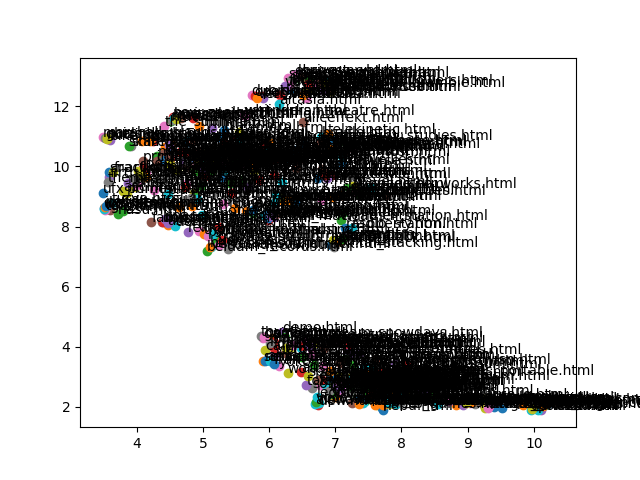

In [7]:
plt.close()

from itertools import count
import random
for post, post_position, post_index in zip(all_posts, umap_result, count()):
    plt.scatter(post_position[0], post_position[1])
    
    plt.annotate(post.title, post_position, post_position)

plt.show()

1.4019612875610534